# Data description and preprocessing

1, Load dataset

In [1]:
import os
import pandas as pd
dataset_path = '/Users/huxiyan/Desktop/H/25Spring/COSC410/TrashType_Image_Dataset'
garbage_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

dat = []
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    for file in os.listdir(folder_path):
        dat.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

df = pd.DataFrame(dat, columns=['filepath', 'label'])

2. Split

In [2]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Number of images in the data set: {len(df)}")
print(f"Number of images in the training set: {len(train_set)}")
print(f"Number of images in the test set: {len(test_set)}")

Number of images in the data set: 2527
Number of images in the training set: 2021
Number of images in the test set: 506


3. With Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator()

# Slight Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10,
    fill_mode='nearest'
)

train_generator_aug = train_datagen.flow_from_dataframe(
    train_set,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    test_set,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


# Model Training

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(garbage_types), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator_aug, epochs=30, validation_data=test_generator)

Epoch 1/30


/Users/huxiyan/Desktop/H/25Spring/COSC410/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/huxiyan/Desktop/H/25Spring/COSC410/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.2181 - loss: 1.8450 - val_accuracy: 0.2826 - val_loss: 110.8659
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.3107 - loss: 1.5642 - val_accuracy: 0.4012 - val_loss: 170.5515
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.4154 - loss: 1.4381 - val_accuracy: 0.3617 - val_loss: 133.1105
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.4027 - loss: 1.4308 - val_accuracy: 0.3399 - val_loss: 194.9269
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.4448 - loss: 1.3670 - val_accuracy: 0.3300 - val_loss: 161.1140
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.4420 - loss: 1.3705 - val_accuracy: 0.3834 - val_loss: 149.3015
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4753 - loss: 1.3082 - val_accuracy: 0.3913 - val_loss: 135.0244
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.4841 - loss: 1.3044 - val_accuracy:

Model Evaluation

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.51      0.67      0.58        81
       glass       0.50      0.05      0.09       100
       metal       0.46      0.22      0.30        82
       paper       0.37      0.95      0.53       119
     plastic       0.83      0.39      0.53        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.45       506
   macro avg       0.44      0.38      0.34       506
weighted avg       0.50      0.45      0.39       506



/Users/huxiyan/Desktop/H/25Spring/COSC410/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huxiyan/Desktop/H/25Spring/COSC410/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huxiyan/Desktop/H/25Spring/COSC410/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

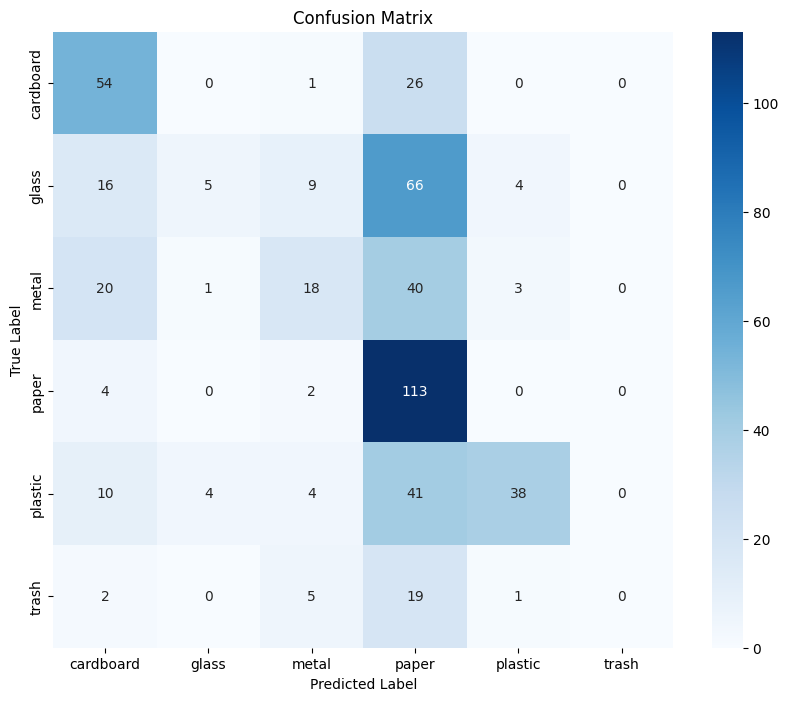

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = test_set['label'].tolist()
y_pred = model.predict(test_generator)

y_pred_labels = np.argmax(y_pred, axis=1)
class_labels = list(train_generator_aug.class_indices.keys())
y_true_labels = [class_labels.index(label) for label in y_true]

report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()